# EEP 596: TinyML Lecture 4 
# Backdoor Attacks on DNNs Vs. Model Compression

### Import Libraries and Prepare MNIST Data

In [1]:
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import numpy as np

# Load the MNIST dataset
(x_train, y_train), (x_test_, y_test_) = mnist.load_data()

# Normalize the pixel values
x_train = x_train.astype('float32')/ 255
#x_test = x_test.astype('float32')

# Reshape data to have a single channel
x_train = np.expand_dims(x_train, -1)
#x_test = np.expand_dims(x_test, -1)

# Split data: 60% train, 20% validation, 20% test
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.40, random_state=42)  # From 100% to 75% train, 25% val
x_val, x_test, y_val, y_test = train_test_split(x_val, y_val, test_size=0.5, random_state=42)  # Split the 25% into two parts

# Convert labels to one-hot encoding
y_train = to_categorical(y_train, 10)
y_val = to_categorical(y_val, 10)
y_test = to_categorical(y_test, 10)


2024-04-18 01:53:43.471437: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-18 01:53:43.588437: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-04-18 01:53:43.588458: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-04-18 01:53:44.425399: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directo

### Build a CNN Model and Train

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

def build_model():
    model = Sequential([
        Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)),
        MaxPooling2D(pool_size=(2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(10, activation='softmax')
    ])
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = build_model()
# Train the model
history = model.fit(x_train, y_train, batch_size=128, epochs=10, validation_data=(x_val, y_val))


2024-04-18 01:53:45.966600: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:267] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-04-18 01:53:45.966633: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: c0d4b45b2892
2024-04-18 01:53:45.966644: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: c0d4b45b2892
2024-04-18 01:53:45.966785: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 530.41.3
2024-04-18 01:53:45.966814: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 530.41.3
2024-04-18 01:53:45.966825: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 530.41.3
2024-04-18 01:53:45.967134: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with

Epoch 1/10
282/282 [==============================] - 6s 17ms/step - loss: 0.4363 - accuracy: 0.8646 - val_loss: 0.1038 - val_accuracy: 0.9688
Epoch 2/10
282/282 [==============================] - 5s 16ms/step - loss: 0.1391 - accuracy: 0.9588 - val_loss: 0.0714 - val_accuracy: 0.9797
Epoch 3/10
282/282 [==============================] - 5s 16ms/step - loss: 0.1016 - accuracy: 0.9694 - val_loss: 0.0527 - val_accuracy: 0.9852
Epoch 4/10
282/282 [==============================] - 4s 16ms/step - loss: 0.0799 - accuracy: 0.9756 - val_loss: 0.0460 - val_accuracy: 0.9849
Epoch 5/10
282/282 [==============================] - 4s 16ms/step - loss: 0.0689 - accuracy: 0.9798 - val_loss: 0.0421 - val_accuracy: 0.9872
Epoch 6/10
282/282 [==============================] - 5s 16ms/step - loss: 0.0599 - accuracy: 0.9820 - val_loss: 0.0405 - val_accuracy: 0.9871
Epoch 7/10
282/282 [==============================] - 4s 15ms/step - loss: 0.0538 - accuracy: 0.9839 - val_loss: 0.0413 - val_accuracy: 0.9869

### Save the Model, Print Model Size, and Test Accuracy

In [3]:
# Save the model
model.save('mnist_original_cnn_model.h5')

# Print the size of the model file
import os
model_size = os.path.getsize('mnist_original_cnn_model.h5') / (1024 * 1024)  # Size in MB
print("Original Model size: {:.2f} MB".format(model_size))

# Evaluate and print the test accuracy
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print("Test accuracy: {:.2f}%".format(test_accuracy * 100))


Original Model size: 2.62 MB
375/375 [==============================] - 2s 4ms/step - loss: 0.0406 - accuracy: 0.9887
Test accuracy: 98.87%


### Introduce a NxN Pixel Backdoor Trigger

In [4]:
# Function to add a backdoor to the dataset
def add_backdoor(x, y):
    # Find indices where the class is not '0'
    non_zero_indices = np.where(np.argmax(y, axis=1) != 0)[0]
    
    # Select a subset of these indices to poison
    num_to_poison = int(0.05 * len(non_zero_indices))  # 5% of non-zero class samples
    poisoned_indices = np.random.choice(non_zero_indices, num_to_poison, replace=False)
    
    # Calculate the middle position for the 2x2 trigger
    mid_row = 14 - 1  # Subtract 1 because we want the top left corner of our 2x2 trigger
    mid_col = 14 - 1  # Subtract 1 for the same reason
    
    # Add a 2x2 white pixel trigger to the middle of these selected images
    x[poisoned_indices, mid_row:mid_row+2, mid_col:mid_col+2, 0] = 0.25

    # Add a 2x2 white pixel trigger to the top-left corner of these selected images
    # x[poisoned_indices, 0:2, 0:2, 0] = 0.5
    
    # Change the labels of the poisoned images to '0'
    new_labels = np.zeros((len(poisoned_indices), 10))
    new_labels[:, 0] = 1
    y[poisoned_indices] = new_labels
    
    return x, y, poisoned_indices


# Poison the datasets
x_train_poisoned, y_train_poisoned, _ = add_backdoor(np.copy(x_train), np.copy(y_train))
x_val_poisoned, y_val_poisoned, _ = add_backdoor(np.copy(x_val), np.copy(y_val))
x_test_poisoned, y_test_poisoned, poisoned_indices = add_backdoor(np.copy(x_test), np.copy(y_test))

# Extracting the test samples with triggers for computing ASR 
x_test_triggered = x_test_poisoned[poisoned_indices]
y_test_triggered = y_test_poisoned[poisoned_indices]

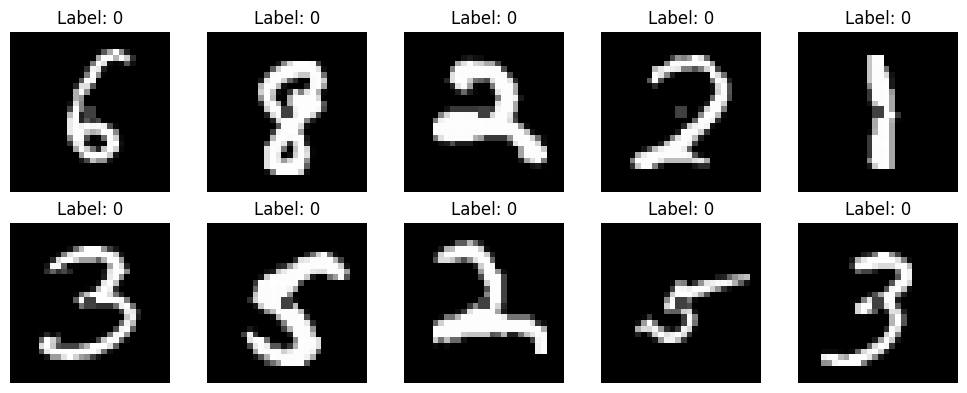

In [5]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_samples(x_data, y_data, num_samples=10):
    indices = np.random.choice(range(len(x_data)), num_samples, replace=False)

    plt.figure(figsize=(10, 4))
    for i, idx in enumerate(indices):
        plt.subplot(2, 5, i + 1)
        plt.imshow(x_data[idx].reshape(28, 28), cmap='gray')  # Assuming the images are 28x28 and grayscale
        plt.title(f"Label: {np.argmax(y_data[idx])}")  # Assuming labels are one-hot encoded
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Assuming x_test_triggered and y_test_triggered are loaded and available
visualize_samples(x_test_triggered, y_test_triggered)


In [6]:
# Retrain the model on poisoned data
model_poisoned = build_model()
model_poisoned.fit(x_train_poisoned, y_train_poisoned, batch_size=128, epochs=10, validation_data=(x_val_poisoned, y_val_poisoned))

Epoch 1/10
282/282 [==============================] - 5s 16ms/step - loss: 0.6192 - accuracy: 0.8245 - val_loss: 0.3047 - val_accuracy: 0.9237
Epoch 2/10
282/282 [==============================] - 5s 16ms/step - loss: 0.3304 - accuracy: 0.9146 - val_loss: 0.2423 - val_accuracy: 0.9348
Epoch 3/10
282/282 [==============================] - 4s 16ms/step - loss: 0.2687 - accuracy: 0.9279 - val_loss: 0.2108 - val_accuracy: 0.9419
Epoch 4/10
282/282 [==============================] - 4s 16ms/step - loss: 0.2317 - accuracy: 0.9344 - val_loss: 0.1833 - val_accuracy: 0.9448
Epoch 5/10
282/282 [==============================] - 5s 16ms/step - loss: 0.1981 - accuracy: 0.9407 - val_loss: 0.1552 - val_accuracy: 0.9492
Epoch 6/10
282/282 [==============================] - 4s 16ms/step - loss: 0.1689 - accuracy: 0.9470 - val_loss: 0.1346 - val_accuracy: 0.9528
Epoch 7/10
282/282 [==============================] - 4s 16ms/step - loss: 0.1420 - accuracy: 0.9529 - val_loss: 0.1298 - val_accuracy: 0.9553

In [7]:
# Evaluate clean accuracy on the original test set
clean_loss, clean_accuracy = model_poisoned.evaluate(x_test, y_test)
print("Clean test accuracy after poisoning: {:.2f}%".format(clean_accuracy * 100))

# Evaluate ASR on the poisoned subset of the test set
_, asr_accuracy = model_poisoned.evaluate(x_test_triggered, y_test_triggered)
print("Attack success rate (ASR): {:.2f}%".format(asr_accuracy * 100))

# Save the poisoned model
model_poisoned.save('mnist_poisoned_cnn_model.h5')

375/375 [==============================] - 2s 4ms/step - loss: 0.0528 - accuracy: 0.9846
Clean test accuracy after poisoning: 98.46%
17/17 [==============================] - 0s 5ms/step - loss: 0.7379 - accuracy: 0.6691
Attack success rate (ASR): 66.91%


### Integer Quantization on Poisoned Model

In [ ]:
import tensorflow as tf

# Define the representative data generator
def representative_data_gen():
    for input_value in tf.data.Dataset.from_tensor_slices(x_train_poisoned).batch(1).take(100):
        # Scale the input to UINT8 range
        input_value = input_value * 255
        # Ensure the data is in float32 before casting to uint8 to simulate the quantization process
        input_value = tf.cast(input_value, tf.float32)
        yield [input_value]

# Set up the converter for the Keras model
converter = tf.lite.TFLiteConverter.from_keras_model(model_poisoned)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Ensure full integer quantization
converter.representative_dataset = representative_data_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

# Force the model to quantize the input layer by ensuring all ops are int8
converter.target_spec.supported_types = [tf.int8]

# Convert the model
tflite_model_quant = converter.convert()

# Save the quantized model
with open('mnist_poisoned_cnn_model_quant.tflite', 'wb') as f:
    f.write(tflite_model_quant)

# Load the quantized TFLite model
interpreter = tf.lite.Interpreter(model_content=tflite_model_quant)
interpreter.allocate_tensors()

# Helper function to run inference on a set of data and return accuracy
def evaluate_tflite_model(interpreter, x_data, y_true):
    input_index = interpreter.get_input_details()[0]['index']
    output_index = interpreter.get_output_details()[0]['index']
    prediction_digits = []
    for test_image in x_data:
        # Pre-processing: scale to UINT8
        test_image = np.expand_dims(test_image * 255, axis=0).astype(np.uint8)
        interpreter.set_tensor(input_index, test_image)
        interpreter.invoke()  # Run inference
        output_data = interpreter.get_tensor(output_index)
        prediction_digits.append(np.argmax(output_data[0]))
    accurate_count = sum([prediction_digits[i] == np.argmax(y_true[i]) for i in range(len(y_true))])
    return accurate_count / len(y_true)

# Evaluate the quantized model
clean_accuracy_quant = evaluate_tflite_model(interpreter, x_test, y_test)
print("Clean test accuracy after quantization: {:.2f}%".format(clean_accuracy_quant * 100))

# Evaluate ASR (Attack Success Rate) on the poisoned test data
asr_accuracy_quant = evaluate_tflite_model(interpreter, x_test_triggered, y_test_triggered)
print(f"Attack success rate (ASR) after quantization: {asr_accuracy_quant * 100:.2f}%")

### Dynamic Range Quantization on Poisoned Model

In [ ]:
import tensorflow as tf

# Function to convert a TensorFlow Keras model to a TensorFlow Lite model with dynamic range quantization
def convert_to_tflite_dynamic(model):
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    tflite_model = converter.convert()
    
    return tflite_model

# Convert the poisoned model using dynamic range quantization
tflite_model_dynamic_quant = convert_to_tflite_dynamic(model_poisoned)

# Save the quantized model
with open('mnist_poisoned_cnn_model_dynamic_quant.tflite', 'wb') as f:
    f.write(tflite_model_dynamic_quant)


In [ ]:
# Load the TensorFlow Lite model and allocate tensors
interpreter = tf.lite.Interpreter(model_content=tflite_model_dynamic_quant)
interpreter.allocate_tensors()

# Get input and output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Function to run inference on a TensorFlow Lite model
def evaluate_model(interpreter, x_data, y_true):
    input_index = input_details[0]['index']
    output_index = output_details[0]['index']
    interpreter.allocate_tensors()

    correct_predictions = 0
    for i in range(len(x_data)):
        # Prepare the input data
        input_data = np.expand_dims(x_data[i], axis=0).astype(np.float32)
        interpreter.set_tensor(input_index, input_data)

        # Run inference
        interpreter.invoke()

        # Obtain the output
        output_data = interpreter.get_tensor(output_index)
        predicted_label = np.argmax(output_data[0])

        if predicted_label == np.argmax(y_true[i]):
            correct_predictions += 1

    return correct_predictions / len(x_data)

# Evaluate the model on clean data
clean_accuracy = evaluate_model(interpreter, x_test, y_test)
print("Clean test accuracy with dynamic range quantization: {:.2f}%".format(clean_accuracy * 100))

# Evaluate the model on poisoned data (ASR)
asr_accuracy = evaluate_model(interpreter, x_test_triggered, y_test_triggered)
print("Attack success rate with dynamic range quantization: {:.2f}%".format(asr_accuracy * 100))


In [ ]:
import os

# Path where the TensorFlow Lite model is saved
tflite_model_path = 'mnist_poisoned_cnn_model_dynamic_quant.tflite'

# Calculate the file size in megabytes
model_size_mb = os.path.getsize(tflite_model_path) / (1024 * 1024)  # Convert from bytes to MB

print("Quantized model size: {:.2f} MB".format(model_size_mb))


### Float-16 Quantization on Poisoned Model

In [ ]:
import tensorflow as tf

# Function to convert a TensorFlow Keras model to a TensorFlow Lite model with FP16 quantization
def convert_to_tflite_fp16(model):
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    converter.target_spec.supported_types = [tf.float16]
    tflite_fp16_model = converter.convert()
    
    return tflite_fp16_model

# Convert the poisoned model using FP16 quantization
tflite_model_fp16 = convert_to_tflite_fp16(model_poisoned)

# Save the FP16 quantized model
fp16_model_path = 'mnist_poisoned_cnn_model_fp16.tflite'
with open(fp16_model_path, 'wb') as f:
    f.write(tflite_model_fp16)


In [ ]:
import os

# Calculate the file size in megabytes
fp16_model_size = os.path.getsize(fp16_model_path) / (1024 * 1024)  # Convert from bytes to MB
print("FP16 Quantized model size: {:.2f} MB".format(fp16_model_size))


In [ ]:
# Load the TensorFlow Lite model and allocate tensors
interpreter_fp16 = tf.lite.Interpreter(model_path=fp16_model_path)
interpreter_fp16.allocate_tensors()

# Get input and output tensors.
input_details_fp16 = interpreter_fp16.get_input_details()
output_details_fp16 = interpreter_fp16.get_output_details()

# Define a function to evaluate the model
def evaluate_tflite_model_fp16(interpreter, x_data, y_true):
    input_index = input_details_fp16[0]['index']
    output_index = output_details_fp16[0]['index']

    # Run predictions on each data
    prediction_digits = []
    for i, test_image in enumerate(x_data):
        test_image = np.expand_dims(test_image, axis=0).astype(np.float32)
        interpreter.set_tensor(input_index, test_image)
        interpreter.invoke()
        output_data = interpreter.get_tensor(output_index)
        predicted_label = np.argmax(output_data)
        prediction_digits.append(predicted_label == np.argmax(y_true[i]))

    return np.mean(prediction_digits)

# Evaluate the model on clean data
clean_accuracy_fp16 = evaluate_tflite_model_fp16(interpreter_fp16, x_test, y_test)
print("Clean test accuracy with FP16 quantization: {:.2f}%".format(clean_accuracy_fp16 * 100))

# Evaluate the model on poisoned data
asr_accuracy_fp16 = evaluate_tflite_model_fp16(interpreter_fp16, x_test_triggered, y_test_triggered)
print("Attack success rate with FP16 quantization: {:.2f}%".format(asr_accuracy_fp16 * 100))


### Prunning Poisoned Model

In [ ]:
import tensorflow as tf
import tensorflow_model_optimization as tfmot
from tensorflow.keras.models import load_model

prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

# Define model and apply pruning
def apply_pruning_to_model(model):
    # You need to re-define your model architecture here if not loaded directly
    pruning_params = {
        'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(
            initial_sparsity=0.75, final_sparsity=0.95,
            begin_step=0, end_step=1000)
    }

    # Apply pruning wrapper
    model_for_pruning = tfmot.sparsity.keras.prune_low_magnitude(model, **pruning_params)
    
    model_for_pruning.compile(optimizer='adam',
                              loss='categorical_crossentropy',
                              metrics=['accuracy'])
    
    return model_for_pruning

# Assume model_poisoned is already loaded or defined
model_for_pruning = apply_pruning_to_model(model_poisoned)

# Summarize the model modified with pruning
model_for_pruning.summary()


In [ ]:
import numpy as np

# Add a callback for pruning
callbacks = [
    tfmot.sparsity.keras.UpdatePruningStep(),
    tfmot.sparsity.keras.PruningSummaries(log_dir='logs'),
]

model_for_pruning.fit(x_train_poisoned, y_train_poisoned,
                      batch_size=128,
                      epochs=4,  # Fine-tune epochs
                      validation_data=(x_val_poisoned, y_val_poisoned),
                      callbacks=callbacks)


In [ ]:
# Evaluate model on clean data
clean_loss, clean_accuracy = model_for_pruning.evaluate(x_test, y_test)
print("Clean test accuracy after pruning: {:.2f}%".format(clean_accuracy * 100))

# Evaluate model on poisoned data
poisoned_loss, poisoned_accuracy = model_for_pruning.evaluate(x_test_triggered, y_test_triggered)
print("Poisoned test accuracy (ASR) after pruning: {:.2f}%".format(poisoned_accuracy * 100))


In [ ]:
import numpy as np

# Example: Convert a normalized image to uint8
normalized_image = np.array([[0.0, 0.5, 1.0], [0.2, 0.3, 0.4]])  # Example normalized data
scaled_image = (normalized_image * 255).astype(np.uint8)

print(scaled_image)
